In [26]:
from pysentimiento import create_analyzer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import matplotlib.gridspec as gridspec

In [2]:
analyzer = create_analyzer(task="emotion", lang="es")

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

In [3]:
directorio = "./paginas_limpias"
archivos = os.listdir(directorio)
to_delete = ['politica_de_prevencion_de_la_corrupcion.txt', 'politica_de_prevencion_de_la_corrupcion_4.txt', 'politica_de_prevencion_de_la_corrupcion_8.txt']
for f in to_delete:
    if f in archivos:
        archivos.remove(f)
print(len(archivos))

8


In [17]:
paginas_dict = {}
paginas_dict["qui"] = '7'
paginas_dict["con"] = '4'
paginas_dict["el_"] = '6'
paginas_dict["pol"] = '9'
paginas_dict["fic"] = '2'
paginas_dict["cor"] = '3'
paginas_dict["por"] = '5'
paginas_dict["asa"] = '8'

emotions = ["joy", "sadness", "anger", "fear", "surprise", "disgust", "others"]

In [4]:
texts = {}
for f in archivos:
    with open(os.path.join(directorio, f), 'r', encoding='utf-8') as file:
        texts[f] = file.read()

In [11]:
results = {}
for text in texts:
    pred = analyzer.predict(texts[text])
    probas_redondeadas = {k: round(v, 2) for k, v in pred.probas.items()}
    results[paginas_dict[text[:3]]] = probas_redondeadas
    print(text)
    print(pred.output, probas_redondeadas)
    print("\n\n")

quito_honesto.txt
others {'others': 0.99, 'joy': 0.0, 'sadness': 0.0, 'anger': 0.0, 'surprise': 0.0, 'disgust': 0.0, 'fear': 0.0}



ficha_limpia_entre_la_hipocresia_y_una_sociedad_sobreadaptada_a_la_corrupcion_la_nacion.txt
anger {'others': 0.02, 'joy': 0.0, 'sadness': 0.01, 'anger': 0.87, 'surprise': 0.0, 'disgust': 0.1, 'fear': 0.0}



el_descontrol_genera_ilegalidades_y_corrupcion_cuba_granma_organo_oficial_del_pcc.txt
anger {'others': 0.11, 'joy': 0.01, 'sadness': 0.01, 'anger': 0.74, 'surprise': 0.01, 'disgust': 0.12, 'fear': 0.0}



politica_de_prevencion_de_la_corrupcion_2.txt
others {'others': 0.59, 'joy': 0.0, 'sadness': 0.02, 'anger': 0.35, 'surprise': 0.0, 'disgust': 0.02, 'fear': 0.01}



por_que_es_indispensable_romper_el_circulo_vicioso_de_la_corrupcion_aunque_sea_dificil_ifac.txt
others {'others': 0.83, 'joy': 0.04, 'sadness': 0.02, 'anger': 0.1, 'surprise': 0.0, 'disgust': 0.01, 'fear': 0.0}



controlar_la_corrupcion_no_es_opcional.txt
anger {'others': 0.01, 'joy': 0.

In [46]:
df = pd.DataFrame.from_dict(results, orient='index')
df = df[emotions]
df.index = df.index.astype(int)
df.loc[1] = 0
df.loc[10] = 0
df = df.sort_index()
df = df*100
df

,joy,sadness,anger,fear,surprise,disgust,others
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,87.0,0.0,0.0,10.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,99.0
4,0.0,3.0,88.0,0.0,0.0,8.0,1.0
5,4.0,2.0,10.0,0.0,0.0,1.0,83.0
6,1.0,1.0,74.0,0.0,1.0,12.0,11.0
7,0.0,0.0,0.0,0.0,0.0,0.0,99.0
8,0.0,1.0,16.0,0.0,1.0,1.0,80.0
9,0.0,2.0,35.0,1.0,0.0,2.0,59.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0


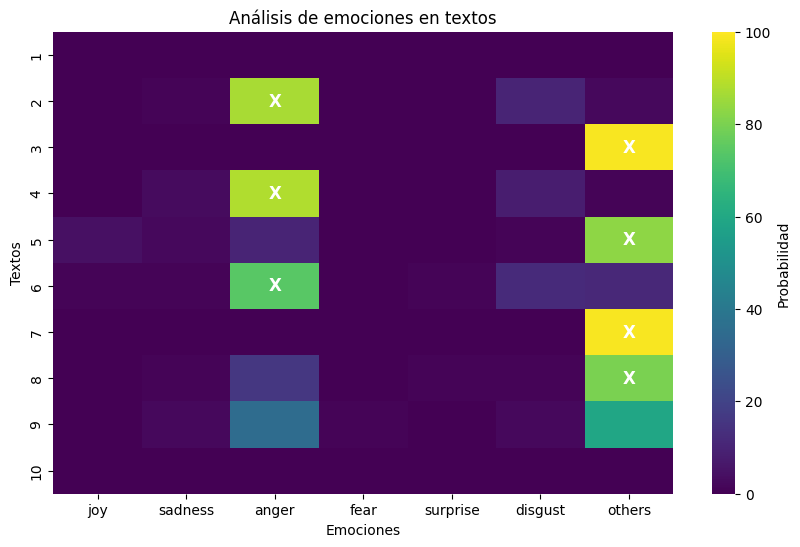

In [48]:
threshold = 60
annot_x = df.map(lambda x: "X" if x >= threshold else "")

plt.figure(figsize=(10, 6))

ax = sns.heatmap(df, 
                 annot=False,  
                 fmt="", 
                 cmap="viridis", 
                 cbar_kws={'label': 'Probabilidad'}, 
                 vmin=0, vmax=100
                )
plt.title("Análisis de emociones en textos")
plt.xlabel("Emociones")
plt.ylabel("Textos")

for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i, j] >= threshold:
            ax.text(j + 0.5, i + 0.5, "X", color='white', ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

In [49]:
path_forms = "./anotaciones_corrupcion_modificado.csv"
df_forms = pd.read_csv(path_forms, header=0)

incisos_emociones = {"a)": "Alegría",
                    "b)": "Tristeza",
                    "c)": "Ira",
                    "d)": "Miedo",
                    "e)": "Sorpresa",
                    "f)": "Vergüenza",
                    "g)": "Culpa",
                    "h)": "Ninguna"
                    }

def extraer_incisos(cadena: str, unico=False):
    """
    Devuelve solo los incisos (a), b), ...) extraídos de la cadena.
    - unico=True: devuelve solo el primer inciso encontrado (o "")
    - unico=False: devuelve todos los incisos separados por espacio
    """
    if not isinstance(cadena, str):
        return ""
    # Busca incisos válidos (ajusta rango [a-i] según tu caso)
    encontrados = re.findall(r'([a-i]\))', cadena.lower())
    if unico:
        return encontrados[0] if encontrados else ""
    else:
        # quitar duplicados preservando orden
        vistos = set()
        unicos = [x for x in encontrados if not (x in vistos or vistos.add(x))]
        return " ".join(unicos)

df_forms.drop(columns=["Marca temporal", "Nombre", "Correo electrónico", "Tiempo aproximado (en minutos) que te tomo revisar el sitio web/texto y contestar todas las preguntas para este sitio web/texto específico:", "Algún comentario adicional que crees que es relevante indicar sobre la página web considerando las preguntas y la temática de corrupción (opcional):\n", "Algún comentario que quieras compartir sobre el cuestionario y la tarea de anotación que estás llevando a cabo (opcional):\n"], inplace=True)
df_forms.rename(columns={"Selecciona una de las 10 páginas a etiquetar": "pagina",
                    "1. Identifica el tipo de entidad que ha publicado el sitio web/texto:": "tipo_entidad",
                    "2. Origen de la entidad que publica el sitio web:": "origen_entidad",
                    '3. Identifica el principal propósito que tiene el contenido del sitio web:': "proposito",
                    '4. El  sitio web/texto principalmente presenta información de forma:': "informacion_presentada",
                    '5. Presenta una visión de la corrupción centrada en:': "vision",
                    '6. Respecto a las consecuencias de la corrupción el  sitio web/texto hace referencia a:': "consecuencias",
                    '7. El  sitio web/texto centra la atención en mostrar:': "que_muestra",
                    '8. Determine cuál es la intención del llamado general hacia el lector:': "intencion",
                    '9. Se presenta la corrupción como como un problema:': "localizacion_problema",
                    '10. Entes involucrados o descritos en el sitio web/texto son:': "involucrados",
                    '11. Respecto al estilo del sitio web/texto, seleccione el nivel de formalidad en el lenguaje:': "formalidad",
                    '12. Estime el nivel de educación necesario para comprender todo el sitio web/texto (o al que parece que se dirigirá el sitio web/texto):': "nivel_educacion",
                    '13. El tono general del sitio web/texto es:': "tono",
                    '14. Apela a alguna de las siguientes emociones:': "emociones"
                    }, inplace=True)

paginas = df_forms["pagina"].unique()
paginas_dict = {i: page[2:] for i, page in enumerate(paginas)}
paginas_dict[9] = paginas_dict[9][1:]

preguntas = df_forms.columns[1:]
multi_answer = ["proposito", "informacion_presentada", "consecuencias", "intencion", "localizacion_problema", "involucrados", "emociones"]

for p in preguntas:
    df_forms[p] = df_forms[p].apply(extraer_incisos, unico=(p not in multi_answer))

num = df_forms['pagina'].astype(str).str.extract(r'^\s*(\d+)')  # captura dígitos al inicio
df_forms['pagina'] = num.fillna(df_forms['pagina']).astype(str)
df_forms['pagina'] = pd.to_numeric(df_forms['pagina'], errors='coerce').astype('Int64')

def calcular_porcentajes(df, pregunta, orden_paginas, posibles_list=None):
    """Devuelve tabla porcentual (páginas × respuestas/incisos)."""
    if posibles_list is None:
        # respuesta única
        tabla = (df.groupby(["pagina", pregunta]).size().unstack(fill_value=0))
        tabla = tabla.reindex(orden_paginas, fill_value=0)
        return tabla.div(tabla.sum(axis=1).replace(0,1), axis=0) * 100
    else:
        # multi-respuesta (incisos separados por espacios)
        posibles_set = set(posibles_list)
        tmp = df[["pagina", pregunta]].copy()
        tmp[pregunta] = tmp[pregunta].fillna("").astype(str).str.strip().str.lower()
        tmp["inciso"] = tmp[pregunta].apply(
            lambda s: list(dict.fromkeys(t for t in s.split() if t in posibles_set))
        )
        den = tmp.groupby("pagina").size().reindex(orden_paginas, fill_value=0)
        expd = tmp.explode("inciso", ignore_index=True)
        expd = expd[expd["inciso"].notna() & (expd["inciso"] != "")]
        counts = expd.groupby(["pagina", "inciso"]).size().unstack(fill_value=0)
        counts = counts.reindex(orden_paginas, columns=posibles_list, fill_value=0)
        return counts.div(den.replace(0,1), axis=0) * 100
    
def conjuntos_activos(porcentajes: pd.DataFrame, umbral: float) -> dict:
    """
    Devuelve {pagina: set(incisos)} con incisos activos por página (>= umbral %).
    porcentajes: DataFrame (index=paginas, columns=incisos) con %.
    """
    activos = {}
    for pag, fila in porcentajes.iterrows():
        incisos = set(fila.index[fila.values >= umbral])
        activos[pag] = incisos
    return activos

def jaccard(act_forms: dict, act_llama: dict, paginas: list) -> pd.Series:
    vals = []
    idx  = []
    for pag in paginas:
        A = act_forms.get(pag, set())
        B = act_llama.get(pag, set())
        union = len(A | B)
        inter = len(A & B)
        score = inter / union if union > 0 else 1.0  # si ambos vacíos, los consideramos iguales (=1)
        vals.append(score); idx.append(pag)
    return pd.Series(vals, index=idx, name="jaccard")


/tmp/ipykernel_11115/280151244.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


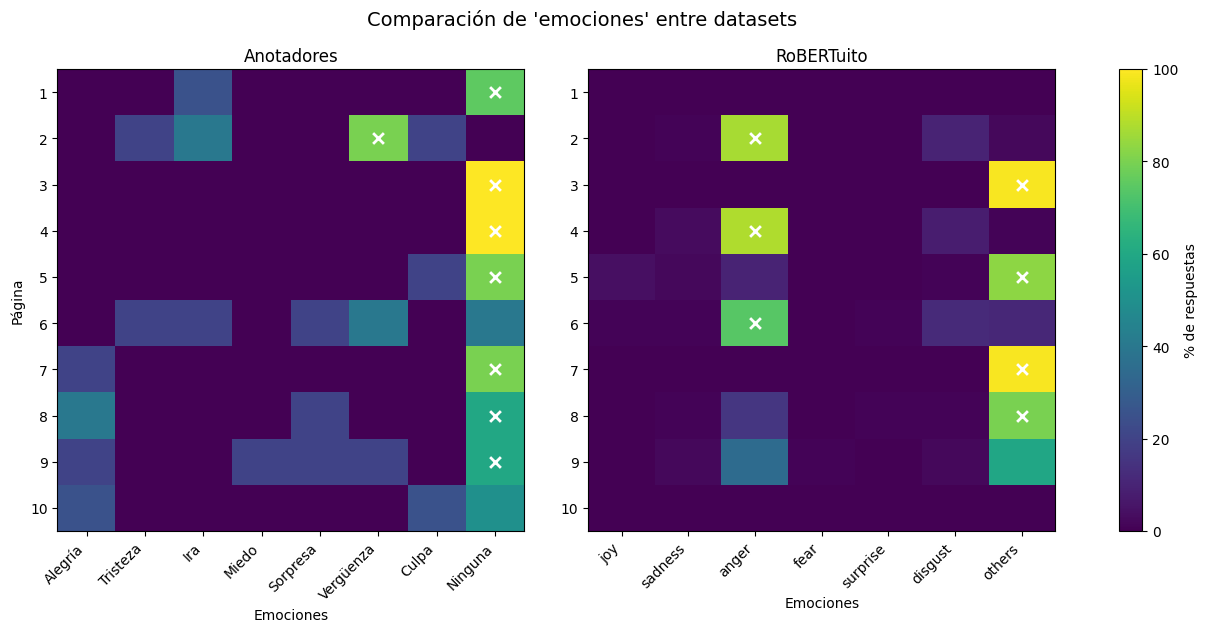

In [44]:
porcentaje_concenso = 60

orden = {}
orden_paginas = list(range(1, 11))

posibles_list = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']

#out = Path("./graficas")
#out.mkdir(exist_ok=True)

# Paleta de colores global
inc = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)"]
colores = plt.cm.tab10.colors  # o 'tab20', 'Set3', etc.
color_map = {c: colores[i % len(colores)] for i, c in enumerate(inc)}

accuracies = []
jaccards = []

porcentajes_emociones = calcular_porcentajes(df_forms, "emociones", orden_paginas, posibles_list)

from matplotlib import gridspec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))

# 3 columnas: [heatmap_1][heatmap_2][colorbar]
gs = gridspec.GridSpec(
    1, 3,
    width_ratios=[1, 1, 0.05],  # la última columna es solo para la barra
    wspace=0.2
)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])  # barra de color vertical

# === Heatmap de anotadores ===
im1 = ax1.imshow(porcentajes_emociones.values, aspect='auto', vmin=0, vmax=100, cmap="viridis")
emociones_labels = [incisos_emociones.get(inc, inc) for inc in porcentajes_emociones.columns]
ax1.set_xticks(range(len(porcentajes_emociones.columns)))
ax1.set_xticklabels(emociones_labels, rotation=45, ha='right')
ax1.set_yticks(range(len(porcentajes_emociones.index)))
ax1.set_yticklabels(porcentajes_emociones.index)
ax1.set_title("Anotadores")
ax1.set_xlabel("Emociones")
ax1.set_ylabel("Página")

# === Marcar celdas con valor ≥ porcentaje_concenso ===
mask = porcentajes_emociones.values >= porcentaje_concenso
ys, xs = np.where(mask)
ax1.scatter(xs, ys, s=60, c='w', marker='x', linewidths=2)

# === Heatmap de modelo (por ejemplo, RoBERTuito) ===
im2 = ax2.imshow(df.values, aspect='auto', vmin=0, vmax=100, cmap="viridis")
ax2.set_xticks(range(len(df.columns)))
ax2.set_xticklabels(df.columns, rotation=45, ha='right')
ax2.set_yticks(range(len(df.index)))
ax2.set_yticklabels(df.index)
ax2.set_title("RoBERTuito")
ax2.set_xlabel("Emociones")
ax2.set_ylabel("")

mask = df.values >= porcentaje_concenso
ys, xs = np.where(mask)
ax2.scatter(xs, ys, s=60, c='w', marker='x', linewidths=2)

# === Barra de color vertical (compartida) ===
cb = fig.colorbar(im1, cax=cax, orientation="vertical")
cb.set_label("% de respuestas")

fig.suptitle("Comparación de 'emociones' entre datasets", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
